# LPR Assignment using OpenCV and Tesseract

Use Optical Character Recognition (OCR) to extract license plate number, aka. vehicle registration number (VRN)
The actual VRN is coded in the file name and also represented in the corresponding meta data file (XML file)

In [1]:
import sys
# sys.path.insert(0, "/opt/opencv-4.4.0/build/python_loader")
import cv2
print(cv2.__version__)

4.4.0


In [2]:
import sys, os
jp = os.path.join
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

##DATADIR = '/data/classes/MSA8650/LPR_project_data'
DATADIR = 'data_redatcted'

## OPENCV = '/opt/local/lib/python3.6/site-packages/cv2/python-3.6'
# OPENCV = '/opt/opencv-4.4.0/build/lib/python3'
# if OPENCV not in sys.path:
#     sys.path.insert(0, OPENCV)
# import cv2
# print(cv2.__version__)

import pytesseract
print(pytesseract.get_tesseract_version())

4.1.1


# Meta Info
Read the XML files and create a table with all the meta information of the samples.

In [3]:
meta_df_filename = jp(DATADIR, 'meta_data.csv')

if os.path.isfile(meta_df_filename):
    print(f"Loading from '{meta_df_filename}'")
    meta_df = pd.read_csv(meta_df_filename)
else:
    xmls_list = [x for x in filter(lambda s: s.endswith('.xml'), map(lambda s: s.strip(), os.popen('ls %s/xml' % DATADIR).readlines()))]
    context_list = [x for x in filter(lambda s: s.endswith('.jpg'), map(lambda s: s.strip(), os.popen('ls %s/context' % DATADIR).readlines()))]
    ir_list = [x for x in filter(lambda s: s.endswith('.jpg'), map(lambda s: s.strip(), os.popen('ls %s/ir_patch' % DATADIR).readlines()))]
    # xmls_list[:3], context_list[:3], ir_list[:3]

    lpdf = pd.DataFrame(index=map(lambda s: s.split('_')[0], xmls_list), data={'xml': xmls_list}) \
            .join( pd.DataFrame(index=map(lambda s: s.split('_')[0], context_list), data={'context': context_list}), how='outer' ) \
            .join( pd.DataFrame(index=map(lambda s: s.split('_')[0], ir_list), data={'ir_patch': ir_list}), how='outer' ) \
            .dropna().copy()
    print(lpdf.shape)
    # display(lpdf.head(5))

    import xml.etree.ElementTree as ET

    meta_df = pd.DataFrame()
    for i, r in lpdf.iterrows():
        tree = ET.parse(jp(DATADIR, 'xml', r.xml))
        el_dict = {}
        for x in tree.iter():
            el_dict[x.tag] = [x.text]
        el_dict
        r_df = pd.DataFrame(el_dict) ##, index=[r.xml])
        r_df.index = [r.xml]
        meta_df = pd.concat([meta_df, r_df])
    for c in ['IRImagePatch', 'ContextImage']:
        print(f'fix {c}')
        meta_df[c] = meta_df[c].map(lambda p: p.replace(r'data_redatcted/', ''))
    meta_df.reset_index(inplace=True)
    meta_df.rename({'index': 'XMLFile'}, axis=1, inplace=True)
    
    num_cols = ['ANPRImageHeight', 'ANPRImageWidth', 'PlateHeight', 'PlateWidth', 'PlateXCoord', 'PlateYCoord', 
            'TagConfidence', 'VRNConfidence', 'Velocity', 'VelocityError', 'XCoord', 'YCoord']
    
    def string2float(x):
        return np.NAN if x==None else float(x)

    for col in num_cols:
        meta_df[col] = meta_df[col].map(string2float)

    meta_df.to_csv(meta_df_filename, index=None)
    
    
print(meta_df.shape)
meta_df.head(5)

Loading from 'data_redatcted/meta_data.csv'
(1839, 31)


,XMLFile,plate_read,InstanceID,CameraID,TimeStamp,TimeStampError,LaneID,VehicleDirection,PlateNotRead,VRN,...,PlateYCoord,PlateWidth,PlateHeight,ANPRImageWidth,ANPRImageHeight,IRImage,IRImagePatch,ContextImage,ContextImagePatch,ContextVideo
0,14134_19700101194928245_BHA6172_1.xml,\n\t,14134,2,1970-01-01T15:49:28.245-0400,0,1,A,0,BHA6172,...,589.0,280.0,80.0,1280.0,1024.0,NaN,ir_patch/14134_19700101194928245_BHA6172_1_ir_...,context/14134_19700101194928245_BHA6172_1_cont...,NaN,NaN
1,14135_19700101195631172_BMU2999_1.xml,\n\t,14135,2,1970-01-01T15:56:31.172-0400,0,1,A,0,BMU2999,...,283.0,280.0,80.0,1280.0,1024.0,NaN,ir_patch/14135_19700101195631172_BMU2999_1_ir_...,context/14135_19700101195631172_BMU2999_1_cont...,NaN,NaN
2,14136_19700101195849178_PFF9889_1.xml,\n\t,14136,2,1970-01-01T15:58:49.178-0400,0,1,A,0,PFF9889,...,583.0,280.0,80.0,1280.0,1024.0,NaN,ir_patch/14136_19700101195849178_PFF9889_1_ir_...,context/14136_19700101195849178_PFF9889_1_cont...,NaN,NaN
3,14137_19700101200204933_PTA2105_1.xml,\n\t,14137,2,1970-01-01T16:02:04.933-0400,0,1,A,0,PTA2105,...,727.0,280.0,80.0,1280.0,1024.0,NaN,ir_patch/14137_19700101200204933_PTA2105_1_ir_...,context/14137_19700101200204933_PTA2105_1_cont...,NaN,NaN
4,14140_19700101200442871_CCD7351_1.xml,\n\t,14140,2,1970-01-01T16:04:42.871-0400,0,1,A,0,CCD7351,...,943.0,280.0,80.0,1280.0,1024.0,NaN,ir_patch/14140_19700101200442871_CCD7351_1_ir_...,context/14140_19700101200442871_CCD7351_1_cont...,NaN,NaN


In [4]:
#! wget https://github.com/opencv/opencv_contrib/raw/master/modules/text/samples/textbox.prototxt

In [5]:
#! wget https://www.dropbox.com/s/g8pjzv2de9gty8g/TextBoxes_icdar13.caffemodel

In [6]:
# Create text detector
textSpotter = cv2.text.TextDetectorCNN_create("textbox.prototxt", "TextBoxes_icdar13.caffemodel")

In [7]:
tessdata = '/usr/local/Cellar/tesseract/4.1.1/share/tessdata/'

In [8]:
whitelist = ''.join([chr(ord('A')+x) for x in range(26)]) \
          + ''.join([str(i) for i in range(10)])
print(whitelist)

ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789


OCR: ''


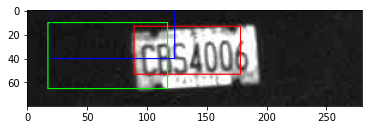

OCR: ''


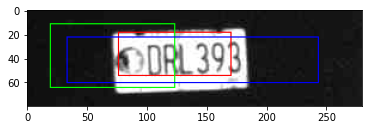

OCR: ''


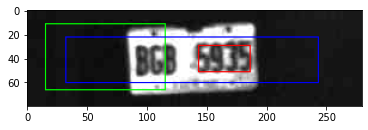

OCR: 'BS 2
'


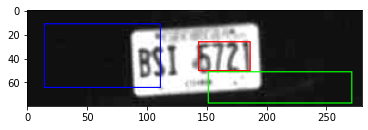

OCR: ''


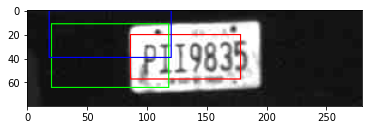

OCR: ''


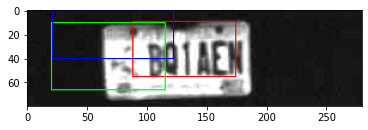

OCR: 'MES
'


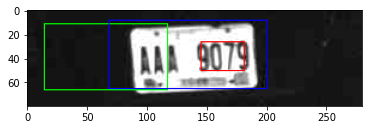

OCR: '195384 B53 4
'


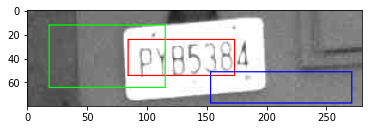

In [9]:
ocr = cv2.text_OCRTesseract.create(tessdata, 'eng', whitelist, cv2.text.OEM_DEFAULT, cv2.text.PSM_SINGLE_LINE)

for k in [40, 60, 61, 230, 478, 1234, 97, 991]:
    row = meta_df.iloc[k]
    # gray = cv2.cvtColor(cv2.imread(jp(DATADIR, row.ContextImage)), cv2.COLOR_BGR2GRAY) ##  cv2.COLOR_BGR2RGB)
    ##ir = cv2.cvtColor(cv2.imread(jp(DATADIR, row.IRImagePatch)), cv2.COLOR_BGR2RGB) ##  cv2.COLOR_BGR2RGB)
    ##ir = cv2.cvtColor(cv2.imread(jp(DATADIR, row.IRImagePatch), 0), cv2.COLOR_GRAY2RGB)
    ir = cv2.imread(jp(DATADIR, row.IRImagePatch), 0)
    
    txt = ocr.run(ir, 10, cv2.text.OCR_LEVEL_TEXTLINE)
    print(f"OCR: '{txt}'")
    
    ir2 = cv2.cvtColor(ir, cv2.COLOR_GRAY2RGB)
    box, confidence = textSpotter.detect(ir2)

    for k in range(3):
        if k>=box.shape[0]: break;
        b = box[k,:]
        clr = [0, 0, 0]
        clr[k] = 255
        ir2 = cv2.rectangle(ir2, (b[0], b[1]), (b[0]+b[2], b[1]+b[3]), tuple(clr), 1)
        
    plt.figure()
    plt.imshow(ir2)
    plt.show(), plt.close()
    

In [67]:
box

array([[ 84,  24,  89,  30],
       [ 18,  12,  97,  52],
       [153,  51, 118,  26],
       [ 45,  18, 141,  45],
       [ 14,  52, 100,  24],
       [ 18,   0, 103,  39],
       [ 35,  22, 105,  31],
       [ 34,  29, 216,  26]], dtype=int32)

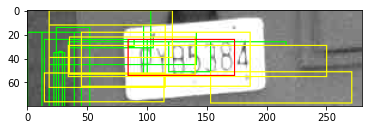

In [72]:
confidence

array([[0.9999325 ],
       [0.02076232],
       [0.01461272],
       [0.01445155],
       [0.01433765],
       [0.01320578],
       [0.01252868],
       [0.0113266 ]], dtype=float32)

In [85]:
ocr = cv2.text_OCRTesseract.create()
txt = cv2.text_OCRTesseract.run(ocr, ir, 50)
print(txt)

In [ ]:
   
    def process(self, inframe, outframe):
        img = inframe.getCvBGR()
        txt = cv2.text_OCRTesseract.run(self.ocr, img, 50)
        jevois.sendSerial('TXT {}'.format(txt))
        outframe.sendCv(img)

# Vehicle Registration Number
I'm trying different image processing steps to prepare the image for OCR.

In [ ]:
import pytesseract
from PIL import Image
from Levenshtein import distance

In [ ]:
meta_df = pd.read_csv(jp(DATADIR, 'meta_data.csv'))
meta_df['VRN_length'] = meta_df.VRN.map(lambda s: len(s))
print(f'Meta-database: {meta_df.shape}')

In [ ]:
meta_df.columns

In [112]:
imfile = jp(DATADIR, row['IRImagePatch'])
print(imfile)
ir = cv2.imread(jp(DATADIR, row['IRImagePatch']))
print(ir.shape)

data_redatcted/ir_patch/15531_19700101180318548_PYB5384_1_ir_patch.jpg
(80, 280, 3)


In [ ]:
!ls -l /data/classes/MSA8650/LPR_project_data/ir_patch/15411_19700101131706973_PWL2646_1_ir_patch.jpg

file: data_redatcted/ir_patch/15411_19700101131706973_PWL2646_1_ir_patch.jpg exists
(80, 280, 3)
(80, 280)


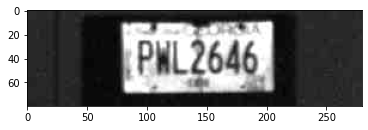

In [113]:
config = "-psm 7 -c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ"

row = meta_df.iloc[898]
img_file = jp(DATADIR, row['IRImagePatch'])
print(f"file: {img_file} {'exists' if os.path.exists(img_file) else 'does not exist'}")
ir = cv2.imread(jp(DATADIR, row['IRImagePatch']))
print(ir.shape)
ir = cv2.cvtColor(ir, cv2.COLOR_BGR2GRAY)
print(ir.shape)
plt.imshow(ir, cmap='gray');
plt.show()
plt.close()

In [115]:
from PIL import Image

In [117]:
config = "--psm 7 -c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ"
res = pytesseract.image_to_string(Image.fromarray(ir), config=config).strip()
print(res)

PHL2646


In [ ]:
np.array(meta_df.VRN.map(lambda s: len(s)))

In [ ]:
meta_df.groupby('VRN_length').agg({'VRN_length': 'count'})

In [ ]:
meta_df.columns

In [ ]:
def load_ir_image(row, quiet=True):
    img_file = jp(DATADIR, row['IRImagePatch'])
    assert os.path.exists(img_file), f"File '{img_file}' does not exist."
    ir = cv2.imread(img_file)
    if not quiet:
        print(ir.shape)
    ir = cv2.cvtColor(ir, cv2.COLOR_BGR2GRAY)
    if not quiet:
        print(ir.shape)
    return ir
          
    
def load_context_image(row, quiet=True):
    img_file = jp(DATADIR, row['ContextImage'])
    assert os.path.exists(img_file), f"File '{img_file}' does not exist."
    ir = cv2.imread(img_file)
    if not quiet:
        print(ir.shape)
    ir = cv2.cvtColor(ir, cv2.COLOR_BGR2RGB)
    if not quiet:
        print(ir.shape)
    return ir
          
    
def show_image(ir):
    plt.imshow(ir, cmap='gray', );
    plt.xticks([], [])
    plt.yticks([],[])
    plt.show()
    plt.close()

In [ ]:
for i, r in meta_df[meta_df.VRN_length==8].iterrows():
    print(r.VRN)
    ir = load_ir_image(r)
    show_image(ir)

In [ ]:
# N = (meta_df.VRN_length==7).sum()
# for i, r in meta_df[meta_df.VRN_length==4].iterrows():
#     print(r.VRN)
#     ir = load_context_image(r)
#     show_image(ir)

In [ ]:
N = (meta_df.VRN_length==4).sum()
for i, r in meta_df[meta_df.VRN_length==4].iterrows():
    print(r.VRN)
    ir = load_ir_image(r)
    show_image(ir)

In [ ]:
row = meta_df.iloc[1]
row

In [ ]:
ir = load_ir_image(row)
show_image(ir)

In [ ]:
from pytesseract import Output

In [ ]:
config = "-psm 7 -c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ"
print(pytesseract.image_to_boxes(ir, config=config))

In [ ]:
      
#gray = cv2.cvtColor(cv2.imread(jp(DATADIR, 'context', row.context)), cv2.COLOR_BGR2GRAY) ##  cv2.COLOR_BGR2RGB)
ir = cv2.cvtColor(cv2.imread(jp(DATADIR, 'ir_patch', row['IRImagePatch'])), cv2.COLOR_BGR2GRAY) ##  cv2.COLOR_BGR2RGB)
plt.imshow(ir, cmap='gray');
plt.show()
plt.close()
# res = pytesseract.image_to_string(Image.fromarray(ir), config=config).strip()
# print(f"VRN: {row.VRN} OCR: {res} Levenshtein distance: {distance(row.VRN, res)}")

# ir = cv2.resize(ir, (int(ir.shape[1]*1.5), ir.shape[0]), interpolation = cv2.INTER_AREA)
# plt.imshow(ir, cmap='gray');
# plt.show()
# plt.close()
# #ir = cv2.adaptiveThreshold(ir,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
# #            cv2.THRESH_BINARY,11,2)
# _ret, ir = cv2.threshold(ir,127,255,cv2.THRESH_BINARY)
# print type(ir)
# plt.imshow(ir, cmap='gray');
# plt.show()
# plt.close()
# ir = cv2.adaptiveThreshold(ir,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
#            cv2.THRESH_BINARY,11,2)
# plt.imshow(ir, cmap='gray');
# plt.show()
# plt.close()
# res = pytesseract.image_to_string(Image.fromarray(ir), config=config).strip()
# print "VRN: %s OCR: %s Levenshtein distance: %d" % (row.VRN, res, distance(row.VRN, res))

Let's test out how well they do

In [ ]:
def process_ir(r):
    config = "-psm 7 -c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ"
    ir = load_ir_image(r)
    res1 = pytesseract.image_to_string(Image.fromarray(ir), config=config).strip()
    
    ir2 = cv2.resize(ir, (int(ir.shape[1]*1.5), ir.shape[0]), interpolation = cv2.INTER_AREA)
    res2 = pytesseract.image_to_string(Image.fromarray(ir2), config=config).strip()
    
    _ret, ir3 = cv2.threshold(ir,127,255,cv2.THRESH_BINARY)
    res3 = pytesseract.image_to_string(Image.fromarray(ir3), config=config).strip()
    
    ir4 = cv2.adaptiveThreshold(ir, 255,
                               cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    res4 = pytesseract.image_to_string(Image.fromarray(ir4), config=config).strip()
    return (res1, res2, res3, res4)

In [ ]:
meta_df['OCR_results'] = meta_df.apply(process_ir, axis=1)

In [ ]:
config = "-psm 7 -c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ"

dist_plain = np.zeros(lpdf2.shape[0], dtype=float)
dist_scale = np.zeros(lpdf2.shape[0], dtype=float)
dist_bin = np.zeros(lpdf2.shape[0], dtype=float)
dist_bin_gauss = np.zeros(lpdf2.shape[0], dtype=float)


max_iter = 100
for i, row in lpdf2.iterrows():
    max_iter -= 1
    if max_iter<0: break
    #gray = cv2.cvtColor(cv2.imread(jp(DATADIR, 'context', row.context)), cv2.COLOR_BGR2GRAY) ##  cv2.COLOR_BGR2RGB)
    ir = cv2.cvtColor(cv2.imread(jp(DATADIR, 'ir_patch', row.ir_patch)), cv2.COLOR_BGR2GRAY) ##  cv2.COLOR_BGR2RGB)
    res = pytesseract.image_to_string(Image.fromarray(ir), config=config).strip()
    dist_plain[i] = distance(row.VRN, res)
    
    ir = cv2.resize(ir, (int(ir.shape[1]*1.5), ir.shape[0]), interpolation = cv2.INTER_AREA)
    res = pytesseract.image_to_string(Image.fromarray(ir), config=config).strip()
    dist_scale[i] = distance(row.VRN, res)

    _ret, ir = cv2.threshold(ir,127,255,cv2.THRESH_BINARY)
    res = pytesseract.image_to_string(Image.fromarray(ir), config=config).strip()
    dist_bin[i] = distance(row.VRN, res)

    ir = cv2.adaptiveThreshold(ir, 255,
                               cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    res = pytesseract.image_to_string(Image.fromarray(ir), config=config).strip()
    dist_bin_gauss[i] = distance(row.VRN, res)

lpdf3 = lpdf2.copy()
lpdf3['dist_plain'] = dist_plain
lpdf3['dist_scale'] = dist_scale
lpdf3['dist_bin'] = dist_bin
lpdf3['dist_bin_gauss'] = dist_bin_gauss

In [ ]:
lpdf3.iloc[:100][['dist_plain', 'dist_scale', 'dist_bin', 'dist_bin_gauss']].describe()

In [ ]:
plt.hist(lpdf3.iloc[:100].dist_bin_gauss)

In [ ]:
row = lpdf2.iloc[278]
ir = cv2.cvtColor(cv2.imread(jp(DATADIR, 'ir_patch', row.ir_patch)), cv2.COLOR_BGR2GRAY) ##  cv2.COLOR_BGR2RGB)
plt.imshow(ir, cmap='gray')
res = pytesseract.image_to_string(Image.fromarray(ir), config=config).strip()
print row.VRN, res, distance(row.VRN, res)

In [ ]:
import imutils
ir2 = imutils.rotate_bound(ir, angle=5)
plt.imshow(ir2, cmap='gray')
res = pytesseract.image_to_string(Image.fromarray(ir2), config=config).strip()
print row.VRN, res, distance(row.VRN, res)

In [ ]:
res = pytesseract.image_to_string(Image.fromarray(ir), config=config).strip()
print row.VRN, res, distance(row.VRN, res)

In [ ]:
row = lpdf3[lpdf3.VehicleDirection=='U'].iloc[0]
ir = cv2.cvtColor(cv2.imread(jp(DATADIR, 'ir_patch', row.ir_patch)), cv2.COLOR_BGR2GRAY) ##  cv2.COLOR_BGR2RGB)
plt.imshow(ir, cmap='gray')
plt.show()
plt.close()

edges = cv2.Canny(ir,50,150,apertureSize = 3)
plt.imshow(edges, cmap='gray')
plt.show()
plt.close()
# This returns an array of r and theta values 
lines = cv2.HoughLines(edges,5,5*np.pi/180, 50)
if lines is not None:
    print len(lines)
else:
    print 0
# The below for loop runs till r and theta values  
# are in the range of the 2d array 
angles = np.array(map(lambda l: l[0][1]*180.0/np.pi, lines[:20]))
print angles
print angles.mean(), np.percentile(angles, 50)
# plt.hist(np.array(map(lambda l: l[0][1]*180.0/np.pi, lines[:2])), bins=20)
# plt.show()
# plt.close()

ir2 = imutils.rotate_bound(ir, angle=90-np.percentile(angles, 50))
plt.imshow(ir2, cmap='gray')
plt.show()
plt.close()
res = pytesseract.image_to_string(Image.fromarray(ir2), config=config).strip()
print row.VRN, res, distance(row.VRN, res)

In [ ]:
np.round(89.999995674289)

In [ ]:
print lines

In [ ]:
plt.hist(np.array(map(lambda l: l[0][1]*180.0/np.pi, lines)), bins=20)

In [ ]:
row = lpdf3[lpdf3.VehicleDirection=='U'].iloc[0]


In [ ]:
len(lines)

In [ ]:
row = lpdf2.iloc[1200]
ir = cv2.cvtColor(cv2.imread(jp(DATADIR, 'ir_patch', row.ir_patch)), cv2.COLOR_BGR2GRAY) ##  cv2.COLOR_BGR2RGB)
plt.imshow(ir, cmap='gray')
res = pytesseract.image_to_string(Image.fromarray(ir), config=config).strip()
print row.VRN, res, distance(row.VRN, res)

In [ ]:
lpdf3.groupby('VehicleDirection')['VehicleDirection'].count()

In [ ]:
for i, row in lpdf3[lpdf3.VehicleDirection=='U'].iloc[:10].iterrows():
    ir = cv2.cvtColor(cv2.imread(jp(DATADIR, 'ir_patch', row['ir_patch'])), cv2.COLOR_BGR2GRAY) ##  cv2.COLOR_BGR2RGB)
    plt.imshow(ir, cmap='gray')
    plt.show()
    plt.close()

In [ ]:
lpdf3.describe().T

# Process Pipeline

In [ ]:
def read_ir_patch(ir_patch):
    return cv2.cvtColor(cv2.imread(jp(DATADIR, 'ir_patch', ir_patch)), cv2.COLOR_BGR2GRAY)


def rotate(img):
    edges = cv2.Canny(img,50,150,apertureSize = 3)

    # This returns an array of r and theta values 
    lines = cv2.HoughLines(edges,5,5*np.pi/180, 50)
    if lines is not None:
        #print len(lines)
        thetas = np.array(map(lambda l: l[0][1]*180.0/np.pi, lines[:20]))
        th = np.round(np.percentile(angles, 50))
        img2 = imutils.rotate_bound(img, angle=90-th)
        return img2
    else:
        return img

    
def show(img):
    plt.imshow(img, cmap='gray')
    plt.show()
    plt.close()
    
    
def scale(img, Sx=1.0, Sy=1.0):
    img2 = cv2.resize(img, (int(img.shape[1]*Sx), int(img.shape[0]*Sy)), interpolation = cv2.INTER_AREA)
    return img2
    

def thresh(img, lo=127, hi=255):
    _ret, img2 = cv2.threshold(img, lo, hi, cv2.THRESH_BINARY)
    return img2


def threshgauss(img, lo=127, hi=255):
    _ret, img2 = cv2.threshold(img, lo, hi, cv2.THRESH_BINARY)
    img3 = cv2.adaptiveThreshold(img2, 255,
                               cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    return img3


config = "-psm 7 -c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ"

lpdf4 = lpdf2.copy()

ls_dist_val = []
ls_dist_idx = []


max_iter = 99999999
for i, row in lpdf2.iterrows():
    max_iter -= 1
    if max_iter<0: break
    #gray = cv2.cvtColor(cv2.imread(jp(DATADIR, 'context', row.context)), cv2.COLOR_BGR2GRAY) ##  cv2.COLOR_BGR2RGB)
    ## ir = cv2.cvtColor(cv2.imread(jp(DATADIR, 'ir_patch', row.ir_patch)), cv2.COLOR_BGR2GRAY) ##  cv2.COLOR_BGR2RGB)
    ir = read_ir_patch(row.ir_patch)
    
    ir2 = scale(ir, Sx=2.0, Sy=2.0)
    ir3 = rotate(ir2)
    ir4 = threshgauss(ir3)
    
    res = pytesseract.image_to_string(Image.fromarray(ir4), config=config).strip()
    d = distance(row.VRN, res)
    ls_dist_val.append(d)
    ls_dist_idx.append(i)
    
    #     ir = cv2.resize(ir, (int(ir.shape[1]*1.5), ir.shape[0]), interpolation = cv2.INTER_AREA)
    #     res = pytesseract.image_to_string(Image.fromarray(ir), config=config).strip()
    #     dist_scale[i] = distance(row.VRN, res)

    #     _ret, ir = cv2.threshold(ir,127,255,cv2.THRESH_BINARY)
    #     res = pytesseract.image_to_string(Image.fromarray(ir), config=config).strip()
    #     dist_bin[i] = distance(row.VRN, res)

    #     ir = cv2.adaptiveThreshold(ir, 255,
    #                                cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    #     res = pytesseract.image_to_string(Image.fromarray(ir), config=config).strip()
    #     dist_bin_gauss[i] = distance(row.VRN, res)

dist_df = pd.DataFrame({'ls_dist': ls_dist_val}, index=ls_dist_idx)
print dist_df.shape
#dist_df.head()
dist_df.groupby('ls_dist')['ls_dist'].count()

In [ ]:
dist_df.groupby('ls_dist')['ls_dist'].count()

In [ ]:
angles = np.array(map(lambda l: l[0][0], lines))

In [ ]:
np.histogram(angles)

In [ ]:
ang2 = sorted(angles)
plt.plot(range(len(ang2)), ang2)